In [2]:
import string
import random
from IPython.display import display, clear_output
from PIL import Image, ImageOps, ImageDraw, ImageFont, ImageChops
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets
from ipywidgets import interactive, HBox, VBox
from img_processing import preprocess_img, DITHER_MODES
from non_mono_char_art_utils import *
from non_mono_char_art_algorithms import *
from generate_char_palette import *
from mono_char_art_conversion_wxh import *
from skimage import metrics

In [3]:
FONT = ImageFont.truetype("fonts/OpenSans-Regular.ttf", 16)
IMG_PATH = "imgs/irad_grad.bmp"

In [4]:
orig_img = Image.open(IMG_PATH).convert("L")
#orig_img = ImageOps.invert(orig_img)

print(orig_img.size)

(512, 512)


In [5]:
def i_preprocess_img(scale_factor, contrast, brightness, quantize_colors, eq, dither):
    proc_img = preprocess_img(orig_img, 0.3, 1.1, 0.5, 0.2, 8, DITHER_MODES.BAYER)
    plt.imshow(proc_img, cmap='gray', vmin=0, vmax=255, interpolation='none')

    plt.figure(figsize=(9, 3))
    plt.xticks([x for x in range(0, len(proc_img.histogram()), 25)])
    plt.bar([x for x in range(0, len(proc_img.histogram()))], proc_img.histogram())
    plt.grid()
    plt.show()

    return proc_img

interactive_preprocess = interactive(i_preprocess_img,
            scale_factor=(0.01, 1, 0.01),
            contrast=(0, 2, 0.01),
            brightness=(0, 2, 0.01),
            eq=(0, 1, 0.01),
            quantize_colors=(1, 256, 1),
            dither=DITHER_MODES)

controls = VBox(interactive_preprocess.children[:-1])
#display(HBox((controls, interactive_preprocess.children[-1])))

In [6]:
proc_img = interactive_preprocess.result

In [7]:
palette = get_asciis()
print(len(palette))
print(palette)

95
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~', ' ']


In [8]:
# char_to_brightness_map = generate_non_mono_multi_char_brightness_map(palette, FONT, 3, 3, normalize=True)
# print(len(char_to_brightness_map))

In [9]:
all_lines = split_lines(proc_img, palette, FONT)
print(len(all_lines))
lines = [all_lines[len(all_lines) // 4], all_lines[len(all_lines) // 2], all_lines[-len(all_lines) // 4]]
for l in all_lines:
    display(l)

7


                                      
           <{qN{}{{            
      ~@MMMMMj}      
     <@MMMMMNi      
     <MMMMMMNi      
       >MMMMMN`       
            <>%%<'''          

0.7698634825831159


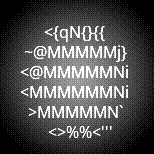

In [10]:
text = greedy_algorithm(proc_img, palette, FONT)
print(''.join(text))

bg_img, draw = new_img_draw(proc_img.size)
draw_text_arr(draw, text, FONT)
print(evaluate_text_arr(text, proc_img, FONT))
ImageChops.add(proc_img, bg_img)

4 0.7383535232274728


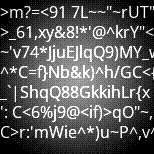

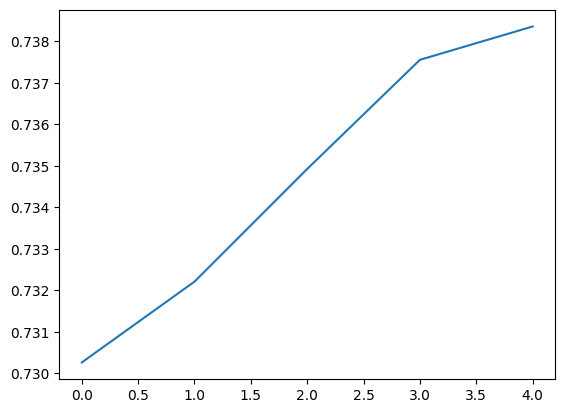

>m?=<91 7L~~"~rUT"
>_61,xy&8!*'@^krY"
~'v74*JjuEJlqQ9)MY_w
^*C=f}Nb&k)^h/GC<{
_`|ShqQ88GkkihLr{x
': C<6%j9@<if)>qO"~,
C>r:'mWie^*)u~P^,v

0.7392013003548527


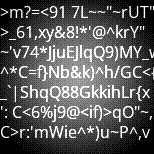

In [11]:
line_finders = [HarmonyLineSearch(line, palette, FONT, 10, 0.9, 0.3, len(palette)//4, False) for line in all_lines]
phs = pool_evolutionary_search(HarmonyLineSearch, line_finders, 20, palette)

res_history = []
for i in range(5):
    text = next(phs)
    clear_output()
    res_history.append(evaluate_text_arr(text, proc_img, FONT))
    print(i, res_history[-1])
    bg_img, draw = new_img_draw(proc_img.size)
    draw_text_arr(draw, text, FONT)
    display(ImageChops.add(proc_img, bg_img))
    plt.plot(res_history)
    plt.show()

for i in range(len(text)):
    text[i] = text[i][:find_end_of_line(text[i], proc_img, FONT)] + '\n'
print(''.join(text))

bg_img, draw = new_img_draw(proc_img.size)
draw_text_arr(draw, text, FONT)
print(evaluate_text_arr(text, proc_img, FONT))
ImageChops.add(proc_img, bg_img)

4 0.7533856517813737


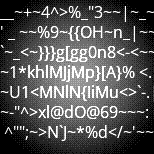

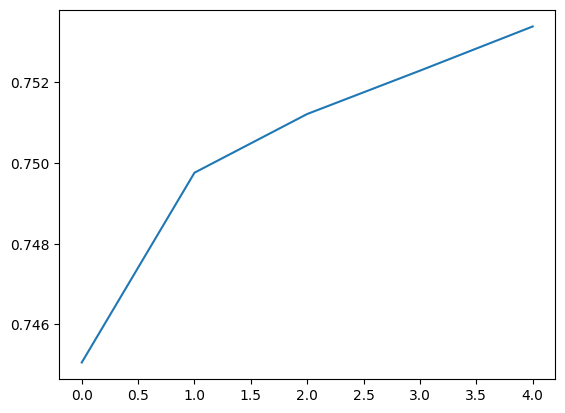

__~+~4^>%_"3~~|~_~
' _ ~~%9~{{OH~n_|~
`~_<~}}}g[gg0n8<-<~~
~1*khlMJjMp}[A}% <.|
~U1<MNlN{IiMu<>`-.
~-"^>xl@dO@69~~~: 
 ^"";~>N`J~*%d</~'~~

0.7535849050363947


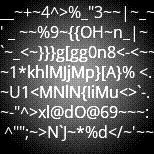

In [12]:
line_finders = [GeneticLineSearch(line, palette, FONT, 100, 0.3, len(palette)//4, False) for line in all_lines]
pgs = pool_evolutionary_search(GeneticLineSearch, line_finders, 20, palette)

res_history = []
for i in range(5):
    text = next(pgs)
    clear_output()
    res_history.append(evaluate_text_arr(text, proc_img, FONT))
    print(i, res_history[-1])
    bg_img, draw = new_img_draw(proc_img.size)
    draw_text_arr(draw, text, FONT)
    display(ImageChops.add(proc_img, bg_img))
    plt.plot(res_history)
    plt.show()

for i in range(len(text)):
    text[i] = text[i][:find_end_of_line(text[i], proc_img, FONT)] + '\n'
print(''.join(text))

bg_img, draw = new_img_draw(proc_img.size)
draw_text_arr(draw, text, FONT)
print(evaluate_text_arr(text, proc_img, FONT))
ImageChops.add(proc_img, bg_img)

4 0.7435883444286806


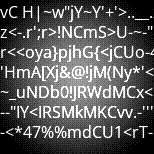

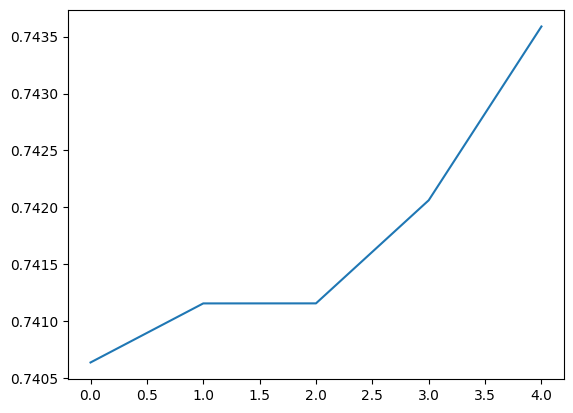

vC H|~w"jY~Y'+'>..__.
z<-.r';r>!NCmS>U-~-"
r<<oya}pjhG{<jCUo-
'HmA[Xj&@!jM(Ny*'<
~_uNDb0!JRWdMCx<
--"IY<IRSMkMKCvv.-''
-<*47%%mdCU1<rT-

0.74407068612569


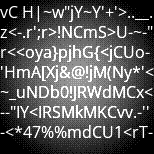

In [13]:

line_finders = [ParticleSwarmLineSearch(line, palette, FONT, 500, 0.3, 2, 1, False) for line in all_lines]
pps = pool_evolutionary_search(ParticleSwarmLineSearch, line_finders, 10, palette)
res_history = []
for i in range(5):
    text = next(pps)
    clear_output()
    res_history.append(evaluate_text_arr(text, proc_img, FONT))
    print(i, res_history[-1])
    bg_img, draw = new_img_draw(proc_img.size)
    draw_text_arr(draw, text, FONT)
    display(ImageChops.add(proc_img, bg_img))
    plt.plot(res_history)
    plt.show()

for i in range(len(text)):
    text[i] = text[i][:find_end_of_line(text[i], proc_img, FONT)] + '\n'
print(''.join(text))

bg_img, draw = new_img_draw(proc_img.size)
draw_text_arr(draw, text, FONT)
print(evaluate_text_arr(text, proc_img, FONT))
ImageChops.add(proc_img, bg_img)
